In [1]:
from models import *
from priors_new import *
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torch.distributions import NegativeBinomial

In [43]:
model_prior = GaussianMixturePrior(latent_dim=1, num_clusters=4)
model_encoder = build_encoder(dim_x=100, h_dim=64, n_layers=2)
model_decoder = build_decoder_nb(dim_x=100, latent_dim=1, h_dim=64, n_layers=2, theta_mode="per_sample")
#opt = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)
model = EmpiricalBayesVariationalAutoencoder(encoder=model_encoder, enc_out_dim=64, decoder=model_decoder, prior=model_prior)

In [44]:
@torch.no_grad()
def generate_clustered_nb_1d(
    n_clusters: int = 4,
    points_per_cluster: int = 300,
    n_features: int = 100,
    latent_dim: int = 1,
    theta_val: float = 12.0,
    theta_per_feature: bool = False,
    theta_vec=None,                      # if None and theta_per_feature=True -> random vector
    theta_rand_sigma: float = 0.35,      # log-space std for random theta vector
    theta_clip: tuple[float, float] | None = (1e-3, 1e3),  # optional safety clip
    cluster_centers=None,
    cluster_spread: float = 0.2,
    seed: int = 42,
    device: str = "cpu",
):
    """
    If theta_per_feature == False:
        theta is scalar (theta_val), broadcast to [N, D].
    If theta_per_feature == True:
        theta is length-D:
            - use `theta_vec` if provided;
            - else sample random per-feature theta ~ LogNormal(log(theta_val), theta_rand_sigma^2).
    Returns:
        X [N,D], labels [N], z [N,latent_dim], centers [K,1], theta_f [D]
    """
    g = torch.Generator(device=device).manual_seed(seed)
    N = n_clusters * points_per_cluster

    # --- cluster centers ---
    if cluster_centers is None:
        centers = torch.linspace(-2, 2, n_clusters, device=device).unsqueeze(1)  # [K,1]
    else:
        centers = torch.tensor(cluster_centers, dtype=torch.float32, device=device).unsqueeze(1)

    # --- latents and labels ---
    labels = torch.arange(n_clusters, device=device).repeat_interleave(points_per_cluster)  # [N]
    z = torch.randn(N, latent_dim, generator=g, device=device) * cluster_spread
    z += centers[labels]

    # --- linear decoder for data gen ---
    W = torch.randn(n_features, latent_dim, generator=g, device=device) / math.sqrt(latent_dim)
    b = torch.randn(n_features, generator=g, device=device) * 0.2

    logits = z @ W.T + b                     # [N, D]
    px_scale = F.softmax(logits, dim=-1)     # [N, D]

    lib = torch.exp(torch.randn(N, 1, generator=g, device=device) * 0.25 + 8.5)
    # fixed library (you can replace with LogNormal if desired)
    #lib = 5000.0
    mu = lib * px_scale                      # [N, D]

    # --- theta construction ---
    if theta_per_feature:
        if theta_vec is not None:
            theta_f = torch.as_tensor(theta_vec, dtype=torch.float32, device=device)
            if theta_f.numel() != n_features:
                raise ValueError(f"`theta_vec` length {theta_f.numel()} != n_features {n_features}")
        else:
            # random per-feature theta ~ LogNormal(log(theta_val), theta_rand_sigma^2)
            log_mean = math.log(max(float(theta_val), 1e-12))
            theta_f = torch.exp(
                torch.randn(n_features, generator=g, device=device) * theta_rand_sigma + log_mean
            )
            if theta_clip is not None:
                lo, hi = theta_clip
                theta_f.clamp_(min=lo, max=hi)
        theta = theta_f.unsqueeze(0).expand(N, -1)  # [N, D]
    else:
        theta_f = torch.full((n_features,), float(theta_val), device=device)
        theta = torch.full_like(mu, float(theta_val))  # [N, D]

    # NB params and sampling
    p = theta / (theta + mu + 1e-8)
    nb = NegativeBinomial(total_count=theta, probs=p)
    X = nb.sample()  # [N, D], integer counts

    return X, labels.cpu(), z.cpu(), centers.cpu(), theta_f.cpu()

In [45]:
# Set up device and generate simulated data
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

#torch.manual_seed(42)

# Generate simulated dataset with 1D latent space
n_clusters = 4
points_per_cluster = 300
n_features = 100
latent_dim = 1

# Define cluster centers in 1D
cluster_centers = [-2.0, -0.75, 0.75, 2.0]  # Well-separated centers

X, y, Z_true, true_centers, theta_used = generate_clustered_nb_1d(
    n_clusters=n_clusters,
    points_per_cluster=points_per_cluster,
    n_features=n_features,
    latent_dim=latent_dim,
    theta_val=12.0,
    theta_per_feature=False,
    cluster_centers=cluster_centers,
    cluster_spread=0.2,  # Tight clusters
    seed=42,
    device=device
)

print(f"Generated dataset:")
print(f"  X shape: {X.shape}")
print(f"  y shape: {y.shape}")
print(f"  Z_true shape: {Z_true.shape}")
print(f"  True cluster centers: {true_centers.flatten().tolist()}")
print(f"  Number of clusters: {n_clusters}")
print(f"  Points per cluster: {points_per_cluster}")

Using device: cuda
Generated dataset:
  X shape: torch.Size([1200, 100])
  y shape: torch.Size([1200])
  Z_true shape: torch.Size([1200, 1])
  True cluster centers: [-2.0, -0.75, 0.75, 2.0]
  Number of clusters: 4
  Points per cluster: 300


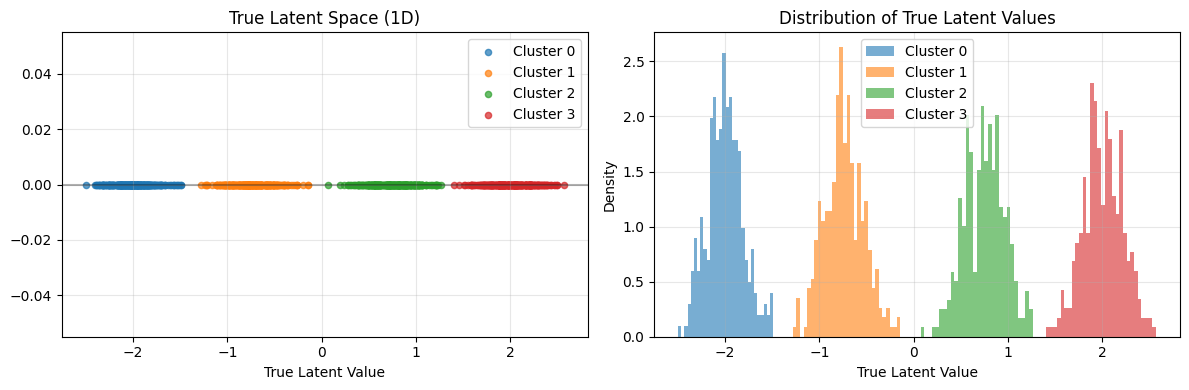

In [46]:
# Visualize the true latent space
plt.figure(figsize=(12, 4))

# Plot 1: True latent values colored by cluster
plt.subplot(1, 2, 1)
for i in range(n_clusters):
    mask = y == i
    plt.scatter(Z_true[mask, 0], np.zeros_like(Z_true[mask, 0]), 
               c=[plt.cm.tab10(i)], label=f'Cluster {i}', alpha=0.7, s=20)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('True Latent Value')
plt.ylabel('')
plt.title('True Latent Space (1D)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Histogram of true latent values by cluster
plt.subplot(1, 2, 2)
for i in range(n_clusters):
    mask = y == i
    plt.hist(Z_true[mask, 0], bins=30, alpha=0.6, label=f'Cluster {i}', density=True)
plt.xlabel('True Latent Value')
plt.ylabel('Density')
plt.title('Distribution of True Latent Values')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [47]:
print(theta_used)
dl = DataLoader(TensorDataset(X.float()), batch_size=128, shuffle=True)
opt = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)
model.to(device)
print(F.softplus(model.decoder._library_u))

tensor([12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,
        12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,
        12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,
        12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,
        12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,
        12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,
        12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,
        12., 12.])
tensor(4000., device='cuda:0', grad_fn=<SoftplusBackward0>)


In [48]:
model.train()
epochs, kl_warm = 400, 50
losses_history = []

print("Starting training...")
for ep in range(1, epochs+1):
    #kl_w = min(21.0, ep / kl_warm)
    kl_w = 1
    tot = 0.0; n = 0
    epoch_losses = {}
    
    for (xb,) in dl:
        xb = xb.to(device).float()
        outputs = model.train_step(xb, opt)
        losses={"loss":outputs["vae-loss"]}
        
        # Accumulate losses
        for key, value in losses.items():
            if key not in epoch_losses:
                epoch_losses[key] = 0.0
            epoch_losses[key] += value.item() * xb.size(0)
        
        tot += losses["loss"].item() * xb.size(0)
        n += xb.size(0)
    
    # Average losses
    for key in epoch_losses:
        epoch_losses[key] /= n
    losses_history.append(epoch_losses)
    
    if ep == 1 or ep % 2 == 0 or ep == epochs:
        #print(f"[{ep:03d}] loss={tot/n:.3f}  kl_w={kl_w:.2f}  recon={epoch_losses.get('recon', 0):.3f}  kl={epoch_losses.get('kl', 0):.3f}")
        print(f"[{ep:03d}] loss={tot/n:.3f}")

print("Training completed!")

Starting training...
[001] loss=15913.790
[002] loss=14366.164
[004] loss=12047.487
[006] loss=9959.861
[008] loss=7588.004
[010] loss=4552.241
[012] loss=2612.316
[014] loss=1605.562
[016] loss=1104.931
[018] loss=741.458
[020] loss=549.143
[022] loss=466.891
[024] loss=423.332
[026] loss=396.030
[028] loss=374.746
[030] loss=354.072
[032] loss=347.955
[034] loss=343.355
[036] loss=335.986
[038] loss=327.014
[040] loss=328.314
[042] loss=319.874
[044] loss=319.972
[046] loss=317.420
[048] loss=323.678
[050] loss=318.457
[052] loss=318.294
[054] loss=313.871
[056] loss=306.558
[058] loss=309.851
[060] loss=306.244
[062] loss=304.983
[064] loss=308.483
[066] loss=306.472
[068] loss=303.955
[070] loss=301.610
[072] loss=302.096
[074] loss=301.443
[076] loss=302.361
[078] loss=302.509
[080] loss=299.944
[082] loss=299.489
[084] loss=299.138
[086] loss=304.106
[088] loss=302.306
[090] loss=299.147
[092] loss=299.417
[094] loss=297.060
[096] loss=302.525
[098] loss=303.461
[100] loss=302.90

In [49]:
model.eval()
with torch.no_grad():
    mu_q = model._define_variational_family(X.float().to(device)).mean

In [50]:
print(mu_q.shape)
print(model.decoder._library_u)

torch.Size([1200, 1])
Parameter containing:
tensor(4000., device='cuda:0', requires_grad=True)


In [24]:
def plot_2d_points(X: torch.Tensor, labels: torch.Tensor | None = None, title="2D points"):
    XY = X.detach().cpu().numpy()          # (1200, 2)
    plt.figure(figsize=(5.5, 5.5))
    if labels is None:
        plt.scatter(XY[:, 0], XY[:, 1], s=10, alpha=0.8)
    else:
        c = labels.detach().cpu().numpy()
        plt.scatter(XY[:, 0], XY[:, 1], c=c, s=10, alpha=0.8)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.xlabel("x1"); plt.ylabel("x2"); plt.title(title)
    plt.tight_layout(); plt.show()

plot_2d_points(mu_q,y)

IndexError: index 1 is out of bounds for axis 1 with size 1

<Figure size 550x550 with 0 Axes>

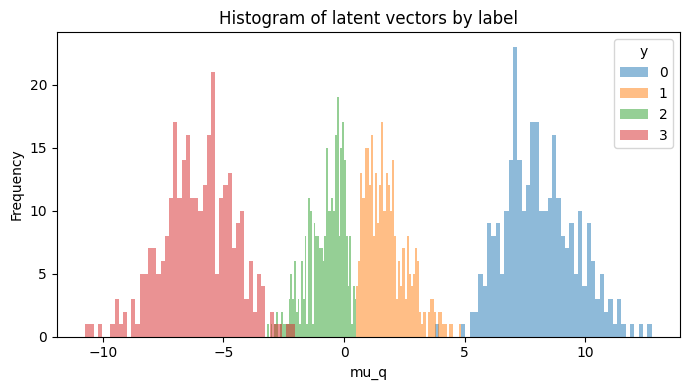

In [51]:
mu = mu_q.detach().flatten().to("cpu").numpy()
labels = y.detach().to("cpu").numpy() if isinstance(y, torch.Tensor) else np.asarray(y)

# choose common bin edges so all histograms align
bins = np.histogram_bin_edges(mu, bins="auto")

# --- plot ---
plt.figure(figsize=(7,4))
for lab in np.unique(labels):
    sel = (labels == lab)
    plt.hist(mu[sel], bins=50, alpha=0.5, label=str(lab))  # counts (frequency)

plt.xlabel("mu_q")
plt.ylabel("Frequency")
plt.title("Histogram of latent vectors by label")
plt.legend(title="y")
plt.tight_layout()
plt.show()

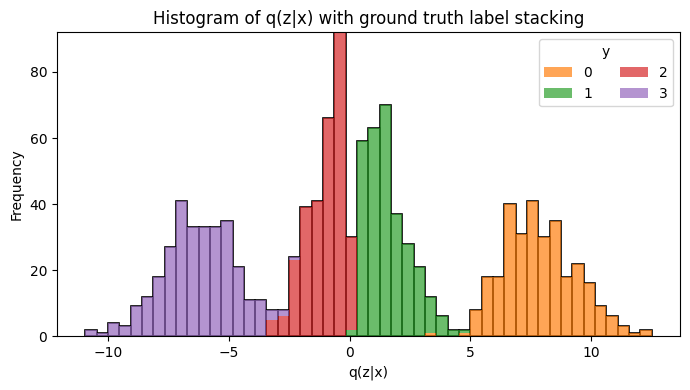

In [52]:
mu = mu_q.detach().flatten().cpu().numpy()
labels = y.detach().cpu().numpy() if isinstance(y, torch.Tensor) else np.asarray(y)

# --- one common binning ---
bins = np.histogram_bin_edges(mu, bins=50)   # or "auto"
left  = bins[:-1]
width = np.diff(bins)

# overall histogram outline (no fill)
total_counts, _ = np.histogram(mu, bins=bins)
plt.figure(figsize=(7,4))
#plt.bar(left, total_counts, width=width, edgecolor='k', fill=False, linewidth=1.2, label='All')
plt.bar(left, total_counts, width=width, edgecolor='k', fill=False, linewidth=1.2)

# per-label stacked fill
bottom = np.zeros_like(total_counts, dtype=float)
for lab in np.unique(labels):
    sel = (labels == lab)
    counts, _ = np.histogram(mu[sel], bins=bins)
    plt.bar(left, counts, width=width, bottom=bottom, label=str(lab), alpha=0.7)
    bottom += counts

plt.xlabel("q(z|x)")
plt.ylabel("Frequency")
plt.title("Histogram of q(z|x) with ground truth label stacking")
plt.legend(title="y", ncol=2)
plt.tight_layout()
plt.show()

In [53]:
#mu_q = mu_q.unsqueeze(1)
resp = model.prior.log_prob_c_z(mu_q.unsqueeze(1))
print(model.prior.mu)

Parameter containing:
tensor([[1.0032],
        [0.0000],
        [0.0000],
        [0.0000]], device='cuda:0', requires_grad=True)


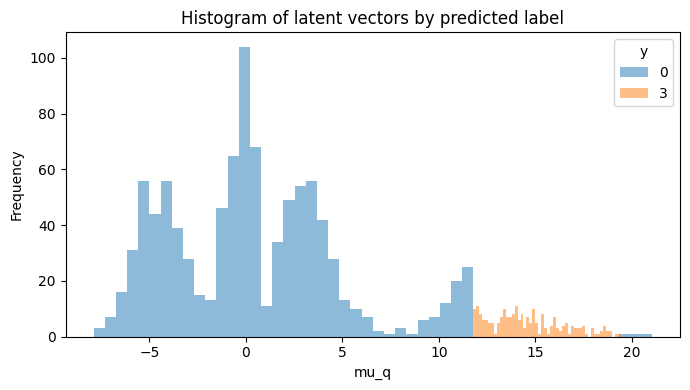

In [28]:
predict_label = resp.argmax(dim=1).detach().cpu().numpy()
bins = np.histogram_bin_edges(mu, bins="auto")

# --- plot ---
plt.figure(figsize=(7,4))
for lab in np.unique(predict_label):
    sel = (predict_label == lab)
    plt.hist(mu[sel], bins=50, alpha=0.5, label=str(lab))  # counts (frequency)

plt.xlabel("mu_q")
plt.ylabel("Frequency")
plt.title("Histogram of latent vectors by predicted label")
plt.legend(title="y")
plt.tight_layout()
plt.show()

In [15]:
model.decoder.theta_param

AttributeError: 'NBDecoder' object has no attribute 'theta_param'

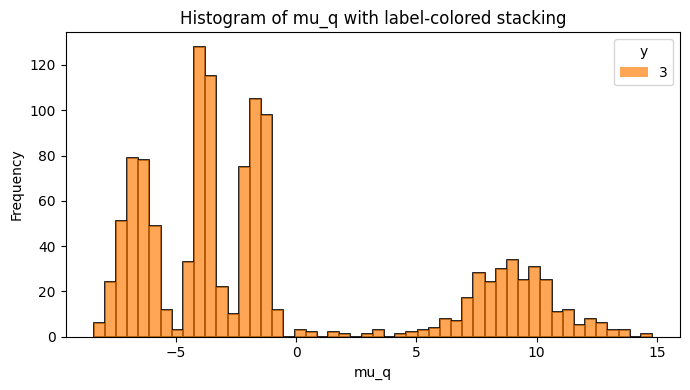

In [48]:
# --- one common binning ---
bins = np.histogram_bin_edges(mu, bins=50)   # or "auto"
left  = bins[:-1]
width = np.diff(bins)

# overall histogram outline (no fill)
total_counts, _ = np.histogram(mu, bins=bins)
plt.figure(figsize=(7,4))
#plt.bar(left, total_counts, width=width, edgecolor='k', fill=False, linewidth=1.2, label='All')
plt.bar(left, total_counts, width=width, edgecolor='k', fill=False, linewidth=1.2)

# per-label stacked fill
bottom = np.zeros_like(total_counts, dtype=float)
for lab in np.unique(predict_label):
    sel = (predict_label == lab)
    counts, _ = np.histogram(mu[sel], bins=bins)
    plt.bar(left, counts, width=width, bottom=bottom, label=str(lab), alpha=0.7)
    bottom += counts

plt.xlabel("mu_q")
plt.ylabel("Frequency")
plt.title("Histogram of mu_q with label-colored stacking")
plt.legend(title="y", ncol=2)
plt.tight_layout()
plt.show()

In [54]:
from sklearn.mixture import GaussianMixture

Z_latent = mu.reshape(-1,1)
model_gmm = GaussianMixture(n_components=4, covariance_type="full", random_state=0).fit(Z_latent)

In [55]:
resp_gmm = model_gmm.predict_proba(Z_latent)
labels_gmm = model_gmm.predict(Z_latent)

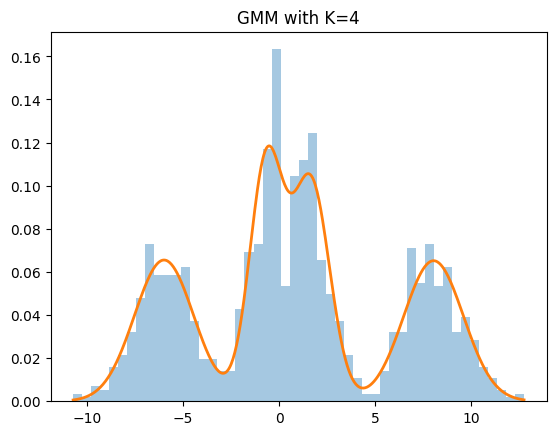

In [56]:
import matplotlib.pyplot as plt
xs = np.linspace(Z_latent.min(), Z_latent.max(), 500)[:, None]
logprob = model_gmm.score_samples(xs)                  # log p(x)
pdf = np.exp(logprob)

plt.figure()
plt.hist(Z_latent, bins=50, density=True, alpha=0.4)
plt.plot(xs, pdf, linewidth=2)
plt.title(f"GMM with K={model_gmm.n_components}")
plt.show()

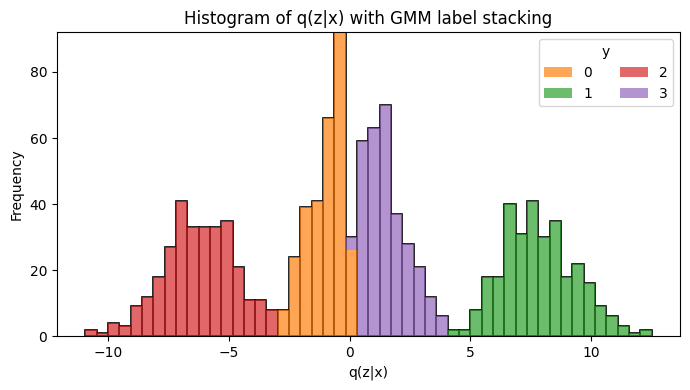

In [57]:
# --- one common binning ---
bins = np.histogram_bin_edges(mu, bins=50)   # or "auto"
left  = bins[:-1]
width = np.diff(bins)

# overall histogram outline (no fill)
total_counts, _ = np.histogram(mu, bins=bins)
plt.figure(figsize=(7,4))
#plt.bar(left, total_counts, width=width, edgecolor='k', fill=False, linewidth=1.2, label='All')
plt.bar(left, total_counts, width=width, edgecolor='k', fill=False, linewidth=1.2)

# per-label stacked fill
bottom = np.zeros_like(total_counts, dtype=float)
for lab in np.unique(labels_gmm):
    sel = (labels_gmm == lab)
    counts, _ = np.histogram(mu[sel], bins=bins)
    plt.bar(left, counts, width=width, bottom=bottom, label=str(lab), alpha=0.7)
    bottom += counts

plt.xlabel("q(z|x)")
plt.ylabel("Frequency")
plt.title("Histogram of q(z|x) with GMM label stacking")
plt.legend(title="y", ncol=2)
plt.tight_layout()
plt.show()

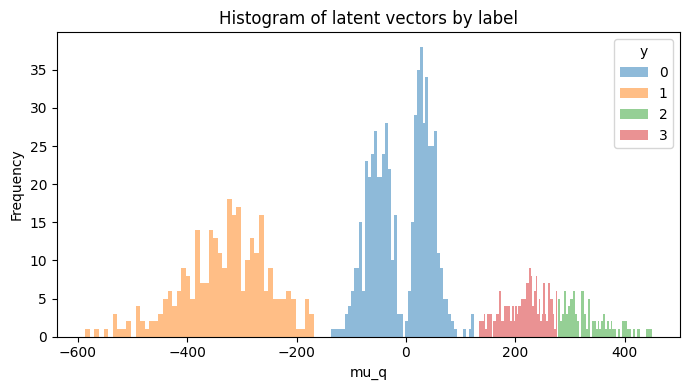

In [129]:
# choose common bin edges so all histograms align
bins = np.histogram_bin_edges(mu, bins="auto")

# --- plot ---
plt.figure(figsize=(7,4))
for lab in np.unique(labels_gmm):
    sel = (labels_gmm == lab)
    plt.hist(mu[sel], bins=50, alpha=0.5, label=str(lab))  # counts (frequency)

plt.xlabel("mu_q")
plt.ylabel("Frequency")
plt.title("Histogram of latent vectors by label")
plt.legend(title="y")
plt.tight_layout()
plt.show()

In [58]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

nmi = normalized_mutual_info_score(labels, labels_gmm, average_method="arithmetic")
ari = adjusted_rand_score(labels, labels_gmm)

print("NMI:", nmi)
print("ARI:", ari)

NMI: 0.9532718889956505
ARI: 0.9691976902832209


In [66]:
import numpy as np
from sklearn.cluster import KMeans

#x = np.asarray(x).reshape(-1, 1)   # (1200,) -> (1200,1)

k = 4  # your chosen number of clusters
km = KMeans(n_clusters=k, n_init=20, random_state=0).fit(Z_latent)

labels_kmeans = km.labels_                 # (1200,) cluster id 0..k-1
centers = km.cluster_centers_.ravel()  # (k,) cluster centers

In [67]:
labels_kmeans

array([2, 2, 2, ..., 1, 1, 1], dtype=int32)

In [68]:
labels = y.detach().to("cpu").numpy() if isinstance(y, torch.Tensor) else np.asarray(y)
nmi = normalized_mutual_info_score(labels, labels_kmeans, average_method="arithmetic")
ari = adjusted_rand_score(labels, labels_kmeans)

print("NMI:", nmi)
print("ARI:", ari)

NMI: 0.8029218129228235
ARI: 0.6354655969771185


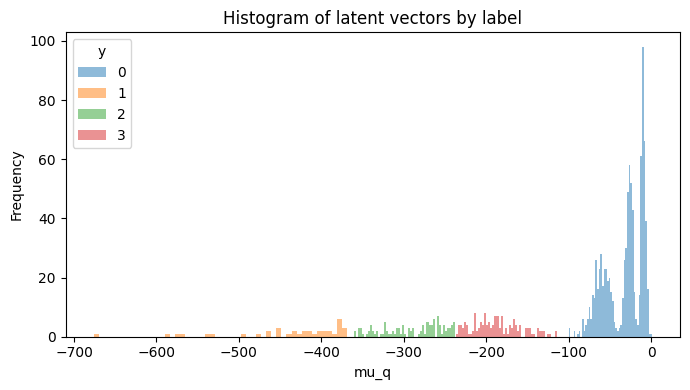

In [26]:
# choose common bin edges so all histograms align
bins = np.histogram_bin_edges(mu, bins="auto")

# --- plot ---
plt.figure(figsize=(7,4))
for lab in np.unique(labels_kmeans):
    sel = (labels_kmeans == lab)
    plt.hist(mu[sel], bins=50, alpha=0.5, label=str(lab))  # counts (frequency)

plt.xlabel("mu_q")
plt.ylabel("Frequency")
plt.title("Histogram of latent vectors by label")
plt.legend(title="y")
plt.tight_layout()
plt.show()

In [148]:
import numpy as np
import scanpy as sc
import anndata as ad

mu = mu_q.detach().flatten().to("cpu").numpy()
x = np.asarray(mu).reshape(-1, 2)        # (N,) -> (N,D)
adata = ad.AnnData(X=x)

# 1) build kNN graph on the 1D feature
sc.pp.neighbors(adata, n_neighbors=10, metric="euclidean")

# 2) Leiden
sc.tl.leiden(adata, resolution=0.05, key_added="leiden")

labels_leiden = adata.obs["leiden"].astype(int).to_numpy() 

In [149]:
np.unique(labels_leiden)

array([0, 1, 2, 3])

In [150]:
labels = y.detach().to("cpu").numpy() if isinstance(y, torch.Tensor) else np.asarray(y)
nmi = normalized_mutual_info_score(labels, labels_leiden, average_method="arithmetic")
ari = adjusted_rand_score(labels, labels_leiden)

print("NMI:", nmi)
print("ARI:", ari)

NMI: 0.9641352039776825
ARI: 0.9757442295255403


In [151]:
# choose common bin edges so all histograms align
bins = np.histogram_bin_edges(mu, bins="auto")

# --- plot ---
plt.figure(figsize=(7,4))
for lab in np.unique(labels_leiden):
    sel = (labels_leiden == lab)
    plt.hist(mu[sel], bins=50, alpha=0.5, label=str(lab))  # counts (frequency)

plt.xlabel("mu_q")
plt.ylabel("Frequency")
plt.title("Histogram of latent vectors by label")
plt.legend(title="y")
plt.tight_layout()
plt.show()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2400 but corresponding boolean dimension is 1200

<Figure size 700x400 with 0 Axes>

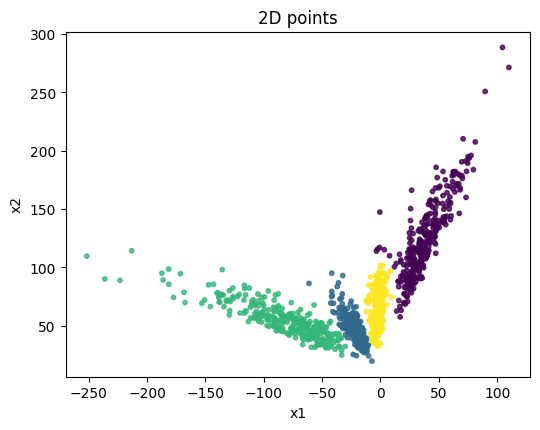

In [153]:
plot_2d_points(mu_q,torch.tensor(labels_leiden))

In [118]:
lib = torch.exp(torch.randn(1200, 1) * 0.25 + 8.5)

In [121]:
lib

tensor([[3688.2410],
        [5645.3149],
        [5263.3574],
        ...,
        [2718.7966],
        [5051.0786],
        [5232.8071]])

In [123]:
X.shape

torch.Size([1200, 100])